In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def contact_potential(dgram, d_0= 2.0, r_0= 8.0):
    divide_by_r_0   = (dgram - d_0) / r_0
    numerator       = np.power(divide_by_r_0,6)
    denominator     = np.power(divide_by_r_0,12)
    potential       = (1 - numerator) / (1 - denominator)
    return potential

def attractive_potential(dgram, r_min=18, r_lin= 17.5):
    potential = get_damped_lj(r_min,r_lin)
    return potential(dgram)


def get_damped_lj(r_min, r_lin, p1=6, p2=12):

    y_at_r_lin = lj(r_lin, r_min, p1, p2)
    ydot_at_r_lin = lj_grad(r_lin, r_min, p1, p2)

    def inner(dgram):
        return (dgram < r_lin) * (ydot_at_r_lin * (dgram - r_lin) + y_at_r_lin) + (dgram >= r_lin) * lj(
            dgram, r_min, p1, p2
        )

    return inner


def lj(dgram, r_min, p1=6, p2=12):
    sigma = r_min / 2 ** (1 / p1)
    eps = 1
    return 4 * eps * ((sigma / dgram) ** p2 - (sigma / dgram) ** p1)


def lj_grad(dgram, r_min, p1=6, p2=12):
    sigma = r_min / 2 ** (1 / p1)
    eps = 1
    return 4 * eps * (- p2 / sigma * (sigma / dgram) ** (p2+1) + p1 / sigma * (sigma / dgram) ** (p1 + 1))
    # return -p2 * r_min**p1 * (r_min**p1 - dgram**p1) / (dgram ** (p2 + 1))

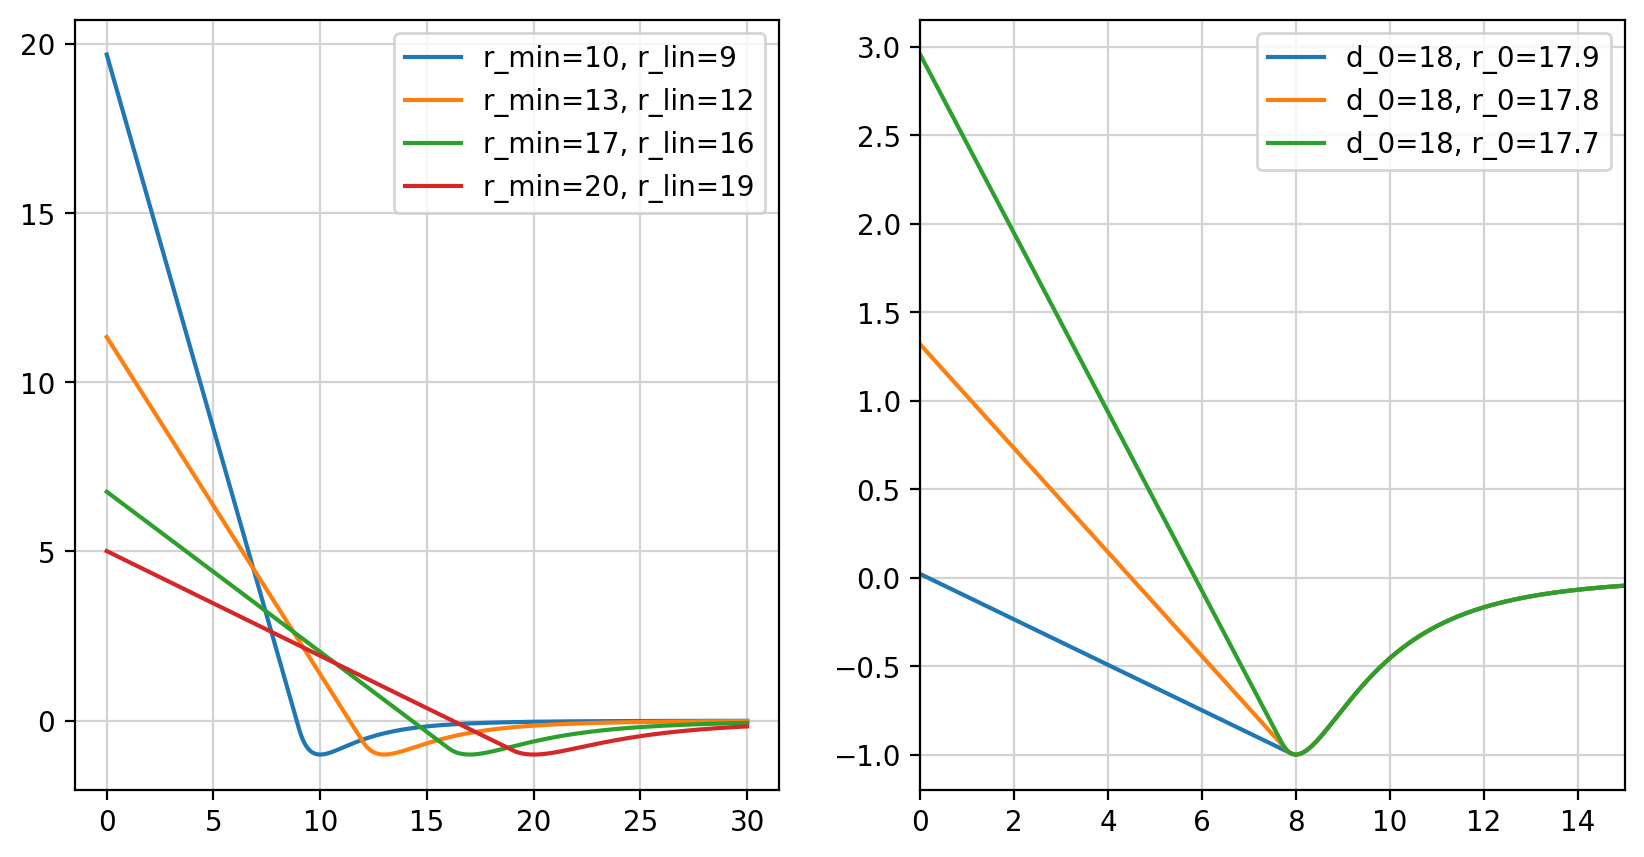

In [4]:
potential = lambda dgram, r_min, r_lin: attractive_potential(dgram, r_min, r_lin) 

dgram = np.linspace(1e-3,30,500)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# For the first subplot
r_min_values = [10, 13, 17, 20]  # different d_0 values for the first subplot
for d_0 in r_min_values:
    ax[0].plot(dgram, potential(dgram, r_min=d_0, r_lin=d_0-1), label=f"r_min={d_0}, r_lin={d_0-1}")
ax[0].grid(':', color="lightgrey")
ax[0].legend()

# For the second subplot
r_0_values = [0.1, 0.2, 0.3]  # different r_0 values for the second subplot
for r_0 in r_0_values:
    ax[1].plot(dgram, potential(dgram, r_min=8.0, r_lin=8.0-r_0), label=f"d_0=18, r_0={18-r_0}")
ax[1].grid(':', color="lightgrey")
ax[1].set_xlim([0,15])
ax[1].legend()
plt.show()

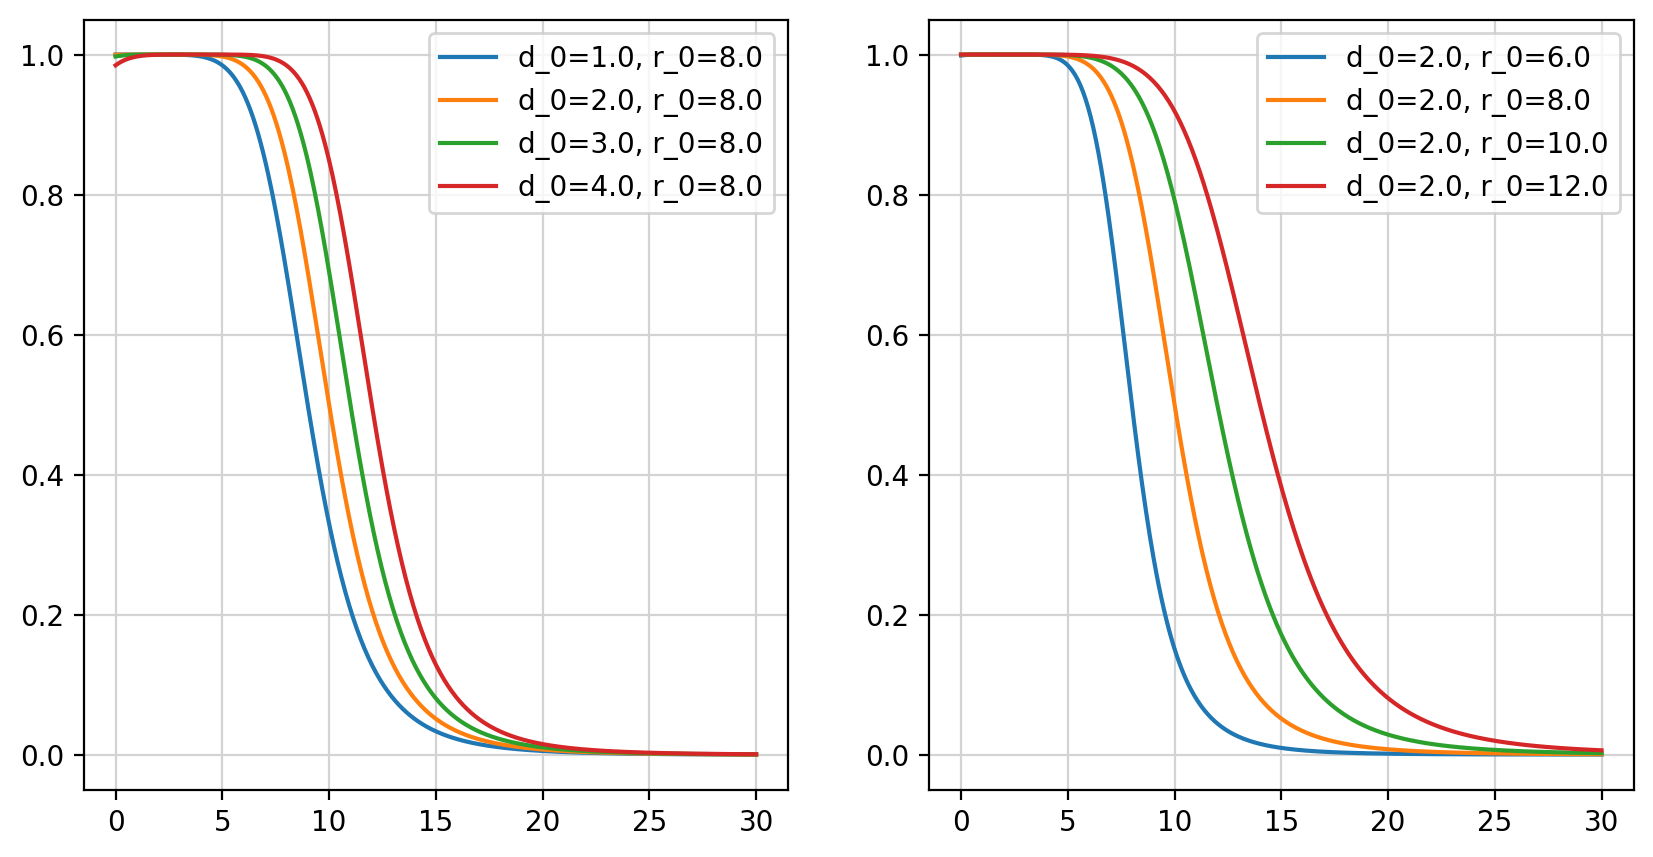

In [5]:
potential = lambda dgram, d_0, r_0: contact_potential(dgram, d_0=d_0, r_0=r_0)

dgram = np.linspace(1e-3,30,500)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# For the first subplot
d_0_values = [1.0, 2.0, 3.0, 4.0]  # different d_0 values for the first subplot
for d_0 in d_0_values:
    ax[0].plot(dgram, potential(dgram, d_0=d_0, r_0=8.0), label=f"d_0={d_0}, r_0=8.0")
ax[0].grid(':', color="lightgrey")
ax[0].legend()

# For the second subplot
r_0_values = [6.0, 8.0, 10.0, 12.0]  # different r_0 values for the second subplot
for r_0 in r_0_values:
    ax[1].plot(dgram, potential(dgram, d_0=2.0, r_0=r_0), label=f"d_0=2.0, r_0={r_0}")
ax[1].grid(':', color="lightgrey")
ax[1].legend()
plt.show()

In [24]:
import torch

# Example function
def func(x):
    return x**2 + 3*x + 5

# Input tensor
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

# Compute output using the function
with torch.no_grad():
    z = func(x)

# Define a loss function, here using Mean Squared Error for demonstration
target = torch.tensor([3.0, 5.0, 7.0])  # example target values
z.requires_grad = True
x.requires_grad = True
loss = torch.mean((z.clone() - target)**2)
# loss = torch.mean((z - target)**2)

# Backpropagate the loss
loss.backward()

# Access the gradient
print("Gradient of z with respect to x:", x.grad)

Gradient of z with respect to x: None


In [25]:
from pathlib import Path
from Bio.PDB import PDBParser

In [39]:
parser = PDBParser()

# Specify the path to your PDB file
PDB_DIR = Path("example_outputs/C8_notebook/")

# get all .pdb files in PDB_DIR
pdb_files = list(PDB_DIR.glob("*.pdb"))

In [40]:

# Function to get C-alpha coordinates from specified chains
def get_ca_coordinates(structure, chain_ids):
    ca_coordinates = {}
    for model in structure:
        for chain in model:
            if chain.id in chain_ids:
                ca_coordinates[chain.id] = []
                for residue in chain:
                    if "CA" in residue:
                        ca = residue["CA"]
                        ca_coordinates[chain.id].append(ca.get_coord())  # Tuple of residue number and coordinates
                ca_coordinates[chain.id] = np.array(ca_coordinates[chain.id])
    return ca_coordinates


In [28]:
from scipy.spatial import distance

In [61]:
import warnings

# Ignore specific warnings from a particular library
warnings.filterwarnings("ignore", module='Bio')

In [62]:
import fnmatch

recent = [f.stem for f in pdb_files if fnmatch.fnmatch(f.stem, '*_2*_*')]

structures = {}

for f in pdb_files:
    structures[f.stem] = get_ca_coordinates(structure = parser.get_structure("Protein_name", f), chain_ids = ['A', 'B'])


Ca = structures[recent[-1]]
pairwise_distances = distance.cdist(Ca["A"], Ca["B"], 'euclidean')


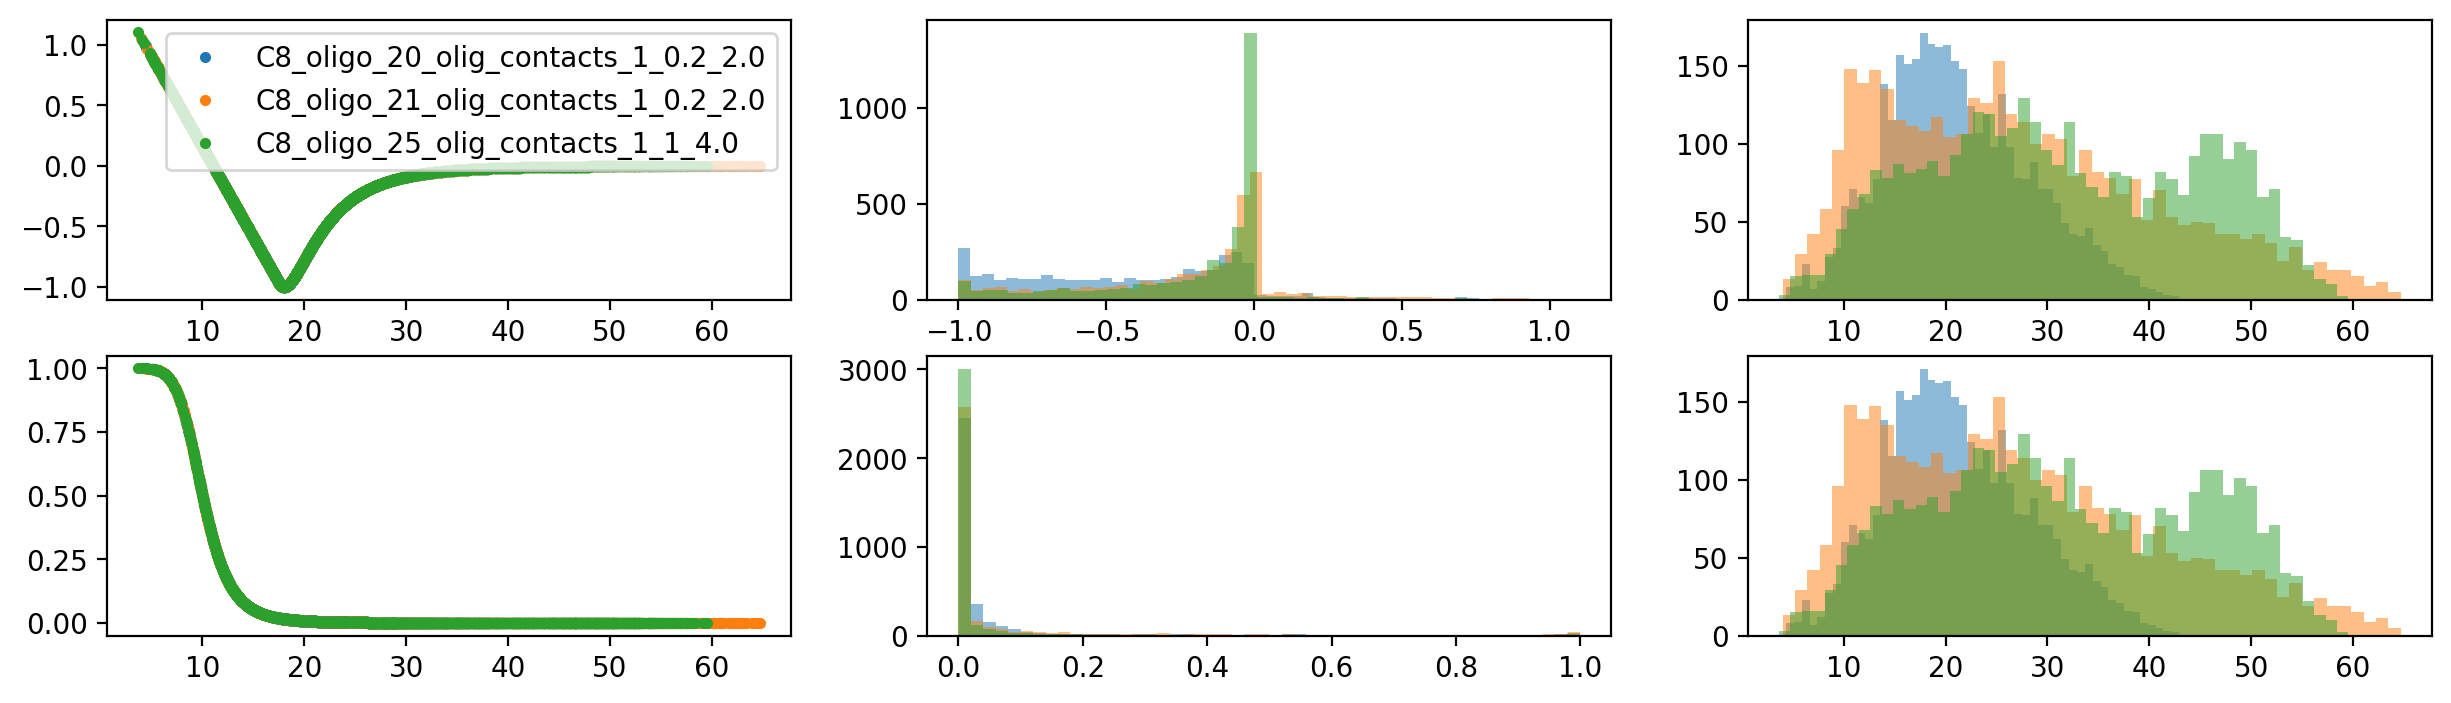

In [71]:
fig, ax = plt.subplots(2, 3, figsize=(15, 4))

i = -1 
j = -4
for i in [0, 1, 2]:
    potential = lambda dgram: attractive_potential(dgram, r_min=18, r_lin=17.5)
    Ca = structures[recent[i]]
    dgram = distance.cdist(Ca["A"], Ca["B"], "euclidean").flatten()
    potential_values = potential(dgram)
    ax[0, 0].plot(dgram, potential_values, ".", label=f"{recent[i]}")
    ax[0, 1].hist(potential_values, bins=50, alpha=0.5)
    ax[0, 2].hist(dgram, bins=50, alpha=0.5)

    potential = lambda dgram: contact_potential(dgram)
    potential_values = potential(dgram)
    ax[1, 0].plot(dgram, potential_values, ".")
    ax[1, 1].hist(potential_values, bins=50, alpha=0.5)
    ax[1, 2].hist(dgram, bins=50, alpha=0.5);

ax[0,0].legend()

[PosixPath('example_outputs/C8_notebook/C8_oligo_20_olig_contacts_1_0.2_2.0.pdb'),
 PosixPath('example_outputs/C8_notebook/C8_oligo_21_olig_contacts_1_0.2_2.0.pdb'),
 PosixPath('example_outputs/C8_notebook/C8_oligo_25_olig_contacts_1_1_4.0.pdb'),
 PosixPath('example_outputs/C8_notebook/C8_oligo_23_olig_contacts_1_0.2_2.0.pdb'),
 PosixPath('example_outputs/C8_notebook/C8_oligo_24_olig_contacts_1_0.2_2.0.pdb')]

In [56]:
pdb_files

[PosixPath('example_outputs/C8_notebook/C8_oligo_11_olig_contacts_0.5_0.2_2.0.pdb'),
 PosixPath('example_outputs/C8_notebook/C8_oligo_20_olig_contacts_1_0.2_2.0.pdb'),
 PosixPath('example_outputs/C8_notebook/C8_oligo_11_olig_contacts_0.5_0.2_0.0.pdb'),
 PosixPath('example_outputs/C8_notebook/C8_oligo_5.pdb'),
 PosixPath('example_outputs/C8_notebook/C8_oligo_21_olig_contacts_1_0.2_2.0.pdb'),
 PosixPath('example_outputs/C8_notebook/C8_oligo_2.pdb'),
 PosixPath('example_outputs/C8_notebook/C8_oligo_25_olig_contacts_1_1_4.0.pdb'),
 PosixPath('example_outputs/C8_notebook/C8_oligo_17_olig_contacts_1_0.2_2.0.pdb'),
 PosixPath('example_outputs/C8_notebook/C8_oligo_10_olig_contacts_1_0.1_2.0.pdb'),
 PosixPath('example_outputs/C8_notebook/C8_oligo_8_olig_contacts_1_0.1_2.0.pdb'),
 PosixPath('example_outputs/C8_notebook/C8_oligo_23_olig_contacts_1_0.2_2.0.pdb'),
 PosixPath('example_outputs/C8_notebook/C8_oligo_13_olig_contacts_1_0.2_2.0.pdb'),
 PosixPath('example_outputs/C8_notebook/C8_oligo_16_o

In [17]:
import torch

xt_in = torch.randn(480,14,3).clone().detach()
xt_in.requires_grad=True
px0 = (3* xt_in - 1)**2
px0.retain_grad()

Ca_i = px0[:60,1]
Ca_j = px0[:60,1]

dgram = torch.cdist(Ca_i[None, ...].contiguous(), Ca_j[None, ...].contiguous(), p=2)

# Select the 10 smallest distances per row
# k=10 for the 10 smallest
# dgram.shape[0] should be 1 here, so we squeeze to remove unnecessary dimensions
dgram = torch.triu(dgram.squeeze(0), diagonal=1).flatten()
dgram = dgram[dgram != 0]
smallest_distances, _ = torch.topk(dgram, k=10, largest=False, sorted=True)

# Define your loss function f, example using mean as a placeholder
def f(x):
    return x.mean()

# Compute the loss only on the 10 smallest distances
loss = f(smallest_distances)
loss.backward()

print(px0.grad[:60,1].mean().item())
print(xt_in.grad[:60,1].mean().item())